## RNN(リカレントニューラルネットワーク）
* これまでのニューラルネットワークはフィードフォワードと呼ばれている。
* 今までのネットワークは時系列データの性質を十分に学習することができない。

#### 言語モデル
* 単語の並びに対して確率を与える。
* 「you say goodbye」 と　「you say good die」とではgoodbyeの方が確率が低いです。
* 数式を使用した言語モデル

$$P(w_1,......,w_n)=\Pi_{t=1}^m(w_t|w_1,....,w_{t-1}) $$
* 上記の結果は確率の乗法定理から導くことができる。
$$P(A,B)=P(A|B)P(B)$$
* Bが起こった後にAが起こる確率という意味。
* これを使用してm個の単語の同時確率を表現することができる。
$$P(w_1....w_{m-1}, w_m)=P(A,w_m)=P(w_m|A)P(A)$$
$$P(w_1....w_{m-2}, w_{m-1})=P(A^`,w_{m-1})=P(w_{m-1}|A^`)P(A^`)$$

* このように単語の並びの並びを一つずつ小さくしながら、繰り返す。（これを**条件付き言語モデル**）

### RNN(Recurrent Neural Network)(何度も繰り返すという意味)
* ループした経路が存在する（情報が絶えず更新される）
* 計算式
$$h_t = tanh(h_{t-1}W_h+x_tW_x+b)$$
#### Symbol
* 入力：x
* 出力：h
* 入力を出力に変えるための重み：W_x
* 一つ前のRNNの出力を次時刻の出力に変換するための重み：W-h
* tanh関数（双曲線正接関数）
* RNNのhは状態を記憶し、１ステップ進むごとに式の形で更新される。
* RNNの出力h_tは**隠れ状態**と呼ばれる。

### Backpropagation Through Time(BPTT)
* 誤差逆伝播法
#### 問題点
* 時系列データの時間サイズが増加するごとに計算リソースも増加し、勾配が不安定になる。
### Truncated BPTT
* 大きな時系列データを扱う際に行われる。
* ネットワークを適当な箇所で切り取り、小さなネットワークを複数形成する。
* シーケンシャル（順番）が大事
#### Truncated BPTT
* バッチ学習する際は開始位置を角バッチごとにずらす必要がある。
* 1000個のデータに対してバッチ数を２とする場合、二つ目のバッチの開始位置は500番目にするといった感じ

In [1]:
import numpy as np
import os
os.chdir("./deep-learning-from-scratch-2-master/")

In [2]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b #RNNの順伝播の式
        h_next = np.tanh(t)　#最後にtanhを追加
        self.cache = (x, h_prev, h_next) #記憶
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt) #Wh
        dh_prev = np.dot(dt, Wh.T) #h_previous
        dWx = np.dot(x.T, dt) #Wx
        dx = np.dot(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev

### Time RNNレイヤの実装

In [2]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None #Time RNNはT個のレイヤから構成される
        self.h, self.dh = None, None
        self.stateful = stateful #フレームワークには引数にstatefulがある
    def set_state(self, h):
        self.h = h
        
    def reset_state(self):
        self.h = None
        
    def forward(self, xs):#xsが入力（時系列データをまとめたもの）
        Wx, Wh, b = self.params
        N, T, D = xs.shape #T個分の時系列データ、バッチサイズをN、次元数をD
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype="f")
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype="f")
            
        for t in range(T):#RNNレイヤの作成、各時刻の隠れ状態を計算しhsに設定（T=t）
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype="f")
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(t)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)#合算した勾配
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        
        return dxs

### RNNLM
* 言語モデルを実装したい
* Embedding→RNN→Afiine→Softmax

In [3]:
from common.time_layers import *
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype("f")
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype("f")
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype("f")
        rnn_b = np.zeros(H).astype("f")
        affine_W = (rn(H, V) / np.sqrt(H).astype("f"))
        affine_b = np.zeros(V).astype("f")
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        self.params, self.grad = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layer):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

#### 言語モデルの評価
* パープレキシティ(perplexity）を使用する。（確率の逆数を取る）
* 小さければ良い精度である。

$$L=-\frac{1}{N}\sum_n\sum_kt_{nk}\log{y_{nk}}$$
$$perplexity=e^L$$

* データ数：N
* n個目のデータのk番目の値:t_nk
* 確率分布:Y_nk
* ニューラルネットワークの損失:L

corpus size: 1000, vocabulary size: 418
| epoch 1 | perplexity 406.70
| epoch 2 | perplexity 293.93
| epoch 3 | perplexity 229.10
| epoch 4 | perplexity 216.14
| epoch 5 | perplexity 206.17
| epoch 6 | perplexity 202.94
| epoch 7 | perplexity 198.71
| epoch 8 | perplexity 196.38
| epoch 9 | perplexity 191.94
| epoch 10 | perplexity 193.38
| epoch 11 | perplexity 188.87
| epoch 12 | perplexity 192.30
| epoch 13 | perplexity 189.72
| epoch 14 | perplexity 190.27
| epoch 15 | perplexity 189.22
| epoch 16 | perplexity 185.54
| epoch 17 | perplexity 184.12
| epoch 18 | perplexity 179.95
| epoch 19 | perplexity 182.05
| epoch 20 | perplexity 182.20
| epoch 21 | perplexity 181.60
| epoch 22 | perplexity 177.55
| epoch 23 | perplexity 172.70
| epoch 24 | perplexity 173.10
| epoch 25 | perplexity 171.07
| epoch 26 | perplexity 172.87
| epoch 27 | perplexity 166.03
| epoch 28 | perplexity 163.85
| epoch 29 | perplexity 166.01
| epoch 30 | perplexity 155.59
| epoch 31 | perplexity 159.05
| epoch 

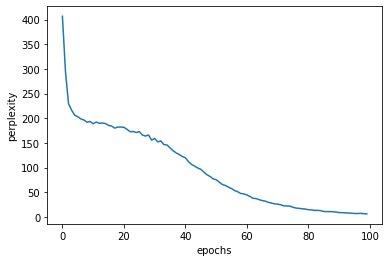

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from ch05.simple_rnnlm import SimpleRnnlm


# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5  # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み（データセットを小さくする）
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# グラフの描画
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()


#### 流れ
* ミニバッチをシーケンシャルに作る。
* モデルの順伝播と逆伝播を呼ぶ。
* オピティマイザで重みを更新
* パープレキシティで評価

| epoch 1 |  iter 1 / 19 | time 0[s] | perplexity 418.42
| epoch 2 |  iter 1 / 19 | time 0[s] | perplexity 394.75
| epoch 3 |  iter 1 / 19 | time 0[s] | perplexity 274.74
| epoch 4 |  iter 1 / 19 | time 0[s] | perplexity 226.26
| epoch 5 |  iter 1 / 19 | time 0[s] | perplexity 213.78
| epoch 6 |  iter 1 / 19 | time 0[s] | perplexity 210.51
| epoch 7 |  iter 1 / 19 | time 0[s] | perplexity 201.39
| epoch 8 |  iter 1 / 19 | time 0[s] | perplexity 201.33
| epoch 9 |  iter 1 / 19 | time 0[s] | perplexity 195.68
| epoch 10 |  iter 1 / 19 | time 0[s] | perplexity 191.60
| epoch 11 |  iter 1 / 19 | time 0[s] | perplexity 192.50
| epoch 12 |  iter 1 / 19 | time 0[s] | perplexity 190.46
| epoch 13 |  iter 1 / 19 | time 0[s] | perplexity 193.28
| epoch 14 |  iter 1 / 19 | time 1[s] | perplexity 188.49
| epoch 15 |  iter 1 / 19 | time 1[s] | perplexity 187.59
| epoch 16 |  iter 1 / 19 | time 1[s] | perplexity 191.95
| epoch 17 |  iter 1 / 19 | time 1[s] | perplexity 190.93
| epoch 18 |  iter 1 / 

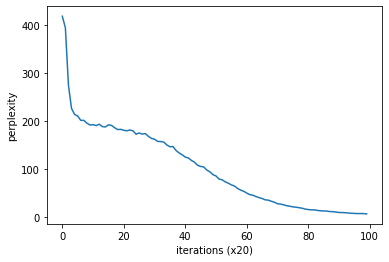

In [7]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer #今後はこれを使う
from dataset import ptb
from ch05.simple_rnnlm import SimpleRnnlm


# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNNの隠れ状態ベクトルの要素数
time_size = 5  # RNNを展開するサイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # テスト用にデータセットを小さくする
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()

In [8]:
from common.trainer import RnnlmTrainer
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)
trainer.fit(xs, ts, max_epoch, batch_size, time_size)

| epoch 1 |  iter 1 / 19 | time 0[s] | perplexity 415.68
| epoch 2 |  iter 1 / 19 | time 0[s] | perplexity 367.06
| epoch 3 |  iter 1 / 19 | time 0[s] | perplexity 258.39
| epoch 4 |  iter 1 / 19 | time 0[s] | perplexity 221.59
| epoch 5 |  iter 1 / 19 | time 0[s] | perplexity 210.60
| epoch 6 |  iter 1 / 19 | time 0[s] | perplexity 209.50
| epoch 7 |  iter 1 / 19 | time 0[s] | perplexity 200.60
| epoch 8 |  iter 1 / 19 | time 0[s] | perplexity 199.96
| epoch 9 |  iter 1 / 19 | time 0[s] | perplexity 195.48
| epoch 10 |  iter 1 / 19 | time 0[s] | perplexity 190.53
| epoch 11 |  iter 1 / 19 | time 0[s] | perplexity 191.67
| epoch 12 |  iter 1 / 19 | time 1[s] | perplexity 188.07
| epoch 13 |  iter 1 / 19 | time 1[s] | perplexity 190.56
| epoch 14 |  iter 1 / 19 | time 1[s] | perplexity 185.74
| epoch 15 |  iter 1 / 19 | time 1[s] | perplexity 185.79
| epoch 16 |  iter 1 / 19 | time 1[s] | perplexity 188.49
| epoch 17 |  iter 1 / 19 | time 1[s] | perplexity 188.07
| epoch 18 |  iter 1 / 